# Modules

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
#% matplotlib inline
pd.set_option('display.max_columns', None)
import time
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import  metrics 
#from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score , f1_score
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
#from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
sns.set(rc={'figure.figsize':(11.7,8.27)})
from sklearn.metrics import confusion_matrix
from xgboost import plot_importance


# Functions

In [2]:
def income_grouping(income):
    
    """
    This function groups the customers income into 4 Categories.
    1. High
    2. Mid-High
    3. Mid-Low
    4. Low
    """
    
    if income < 49000.0:
        grouping = 'Low'
    elif ((income>=49000.0) and (income<64000.0)):
        grouping = 'Mid-Low'
    elif ((income>=64000.0) and (income<80000.0)):
        grouping = 'Mid-High'
    elif ((income>=80000.0)):
        grouping = 'High'
        
    return grouping


def age_grouping(age):
    
    """
    This function groups the customers Age into 4 Categories.
    1. under 30
    2. 30 - 50
    3. 50 - 70
    4. 70 - end
    """
    
    if age < 30:
        grouping = 'under 30'
    elif ((age>=30) and (age<50)):
        grouping = '30 - 50'
    elif ((age>=50) and (age<70)):
        grouping = '50 - 70'
    elif ((age>=70)):
        grouping = '70 - end'
        
    return grouping

features_to_scale = ['difficulty', 'reward' ,'duration', 'Amount_spent' , 'Transaction_count' , 'time']

def feature_scaler(df, features):
    
    
    """
    This function is used to scale features
    
    INPUT:
    - df (dataframe): Dataframe with scalable features
    - features (list): List of features to scale
            
    OUTPUT:
    - df_scaled (dataframe): Scaled features dataframe
    """
        
    df_feat_scale = df[features]
        
    scaler = MinMaxScaler()
    df_feat_scale = pd.DataFrame(scaler.fit_transform(df_feat_scale), columns = df_feat_scale.columns,index=df_feat_scale.index)
        
    df = df.drop(columns=features, axis=1)
    df_scaled = pd.concat([df, df_feat_scale], axis=1)
        
    return df_scaled

def days_since_member(current_date, max_date = ('2018-07-26 00:00:00')):
    max_date = pd.to_datetime(max_date)
    return abs((max_date - current_date).days)

def membership_grouping(membership):
    
    """
    This function groups the customers income into 4 Categories.
    1. New Members
    2. Moderate Members
    3. Long Term Members
    4. Very Long Term Members
    """
    
    if membership < 100:
        grouping = 'New Members'
    elif ((membership>=100) and (membership<500)):
        grouping = 'Moderate Members'
    elif ((membership>=500) and (membership<1000)):
        grouping = 'Long Term Members'
    elif ((membership>=1000)):
        grouping = 'Very Long Term Members'
        
    return grouping

def channel_appender(list_channels):
    
    """
    This function groups the customers income into 4 Categories.
    1. New Members
    2. Moderate Members
    3. Long Term Members
    4. Very Long Term Members
    """
    
    
    all_list = ['web' , 'email' , 'mobile' , 'social']
    all_listl_values = [1,1,1,1]
    
    diff = list(set(all_list) - set(list_channels))
    for i in range(0,len(diff)):
        ind = all_list.index(diff[i])
        all_listl_values[ind] = 0
    web = all_listl_values[0] 
    email = all_listl_values[1] 
    mobile = all_listl_values[2] 
    social = all_listl_values[3] 
    

    return web,email,mobile,social



# Profiles

In [3]:
# Loading profile data
profile = pd.read_json('profile.json', orient='records', lines=True)
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [4]:
profile.dtypes

age                   int64
became_member_on      int64
gender               object
id                   object
income              float64
dtype: object

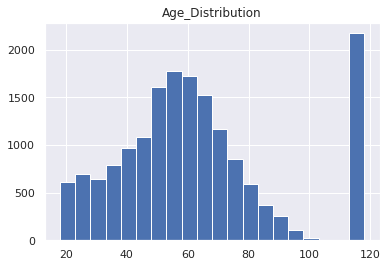

In [5]:
# Age Histogram
profile['age'].hist(bins=20)
plt.title('Age_Distribution')
plt.savefig('Age_Distribution')

In [6]:
#Excluding Anomalies
profiles = profile[profile['gender'].notnull()]

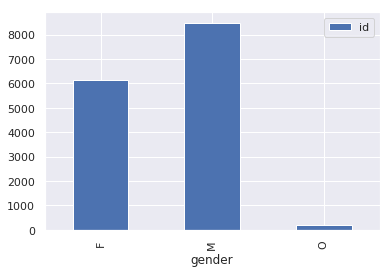

In [7]:
profiles.groupby('gender').count()['id'].reset_index().plot(x='gender' , kind='bar')
plt.savefig('Gender_Distribution')

In [8]:
# Excluding 'O' due to case imbalance
profiles= profiles[profiles['gender']!='O']
profiles.head()

,age,became_member_on,gender,id,income
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In [9]:
# Creating age and income categories
profiles['income_grouping'] = profiles['income'].apply(lambda x : income_grouping(x))
profiles['age_grouping'] = profiles['age'].apply(lambda x : age_grouping(x))
del profiles['age']
del profiles['income']

In [10]:
# Membership Breakdown
profiles['year'] = profiles['became_member_on'].apply(lambda x:str(x)[0:4])
profiles['month'] = profiles['became_member_on'].apply(lambda x:str(x)[4:6])
profiles['day'] = profiles['became_member_on'].apply(lambda x:str(x)[6:8])
del profiles['became_member_on']

profiles.sort_values(by=['year' , 'month' , 'day'] , ascending=[0,0,0] , inplace=True)
profiles['Date'] = pd.to_datetime(profiles[['year','month','day']])
del profiles ['day']
del profiles ['month']
del profiles ['year']

profiles['days_since_member'] = profiles['Date'].apply(lambda x : days_since_member(x))
del profiles['Date']

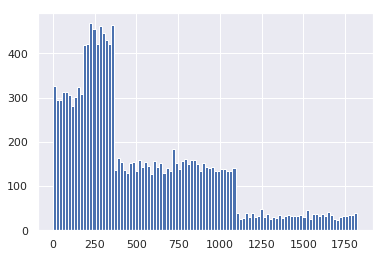

In [11]:
fig, ax = plt.subplots()
profiles['days_since_member'].hist(bins=100 , ax=ax)
fig.savefig('days_since_member')


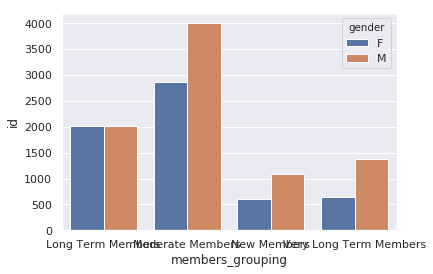

In [12]:
#Grouping Members
profiles['members_grouping'] = profiles['days_since_member'].apply(lambda x : membership_grouping(x))
del profiles['days_since_member']
member_grouping = profiles.groupby(['members_grouping' , 'gender']).count()['id'].reset_index()

figg = sns.barplot(x='members_grouping', y='id', hue='gender', data=member_grouping)


In [13]:
figg.figure.savefig("members_grouping.png")

In [14]:
#Encoding Profile Features

le = LabelEncoder()
profiles = profiles[['id' , 'gender' , 'income_grouping' , 'age_grouping' , 'members_grouping']]
profiles['gender'] = le.fit_transform(profiles['gender'])
profiles['income_grouping'] = le.fit_transform(profiles['income_grouping'])
profiles['age_grouping'] = le.fit_transform(profiles['age_grouping'])
profiles['members_grouping'] = le.fit_transform(profiles['members_grouping'])


profiles.head()

,id,gender,income_grouping,age_grouping,members_grouping
167,4e233f02eff840c7a3e5ec15d55d7d23,1,2,2,2
452,b65eaba56d124588aed15c484db427a8,1,2,1,2
689,70f115dc7bf84a2ca3b1481639590f2b,1,3,0,2
1517,267e47de94fd46b1afa96dea1c9d3cbf,1,1,3,2
2709,4be45187b24d479fbccaf1f6293ebff8,1,3,0,2


# Portfolio

In [15]:
# Loading Portfolio
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [16]:
# Encoding Channels
le = LabelEncoder()
portfolio = portfolio[['id' ,'offer_type' , 'channels' , 'difficulty' , 'duration' , 'reward']]
portfolio['channels'] = le.fit_transform(portfolio['channels'].astype(str))

In [17]:
# Encoding Offer Types
portfolio['offer_id_encoded'] = le.fit_transform(portfolio['id'])
portfolio

,id,offer_type,channels,difficulty,duration,reward,offer_id_encoded
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,0,10,7,10,7
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,1,10,5,10,4
2,3f207df678b143eea3cee63160fa8bed,informational,2,0,4,0,3
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,2,5,7,5,6
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,3,20,10,5,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,1,7,7,3,1
6,fafdcd668e3743c1bb461111dcafc2a4,discount,1,10,10,2,9
7,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,3,0,5
8,f19421c1d4aa40978ebb69ca19b0e20d,bogo,1,5,5,5,8
9,2906b810c7d4411798c6938adc9daaa5,discount,2,10,7,2,2


In [18]:
#Converting duration from days to hours
portfolio['duration'] = portfolio['duration']*24
portfolio

,id,offer_type,channels,difficulty,duration,reward,offer_id_encoded
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,0,10,168,10,7
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,1,10,120,10,4
2,3f207df678b143eea3cee63160fa8bed,informational,2,0,96,0,3
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,2,5,168,5,6
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,3,20,240,5,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,1,7,168,3,1
6,fafdcd668e3743c1bb461111dcafc2a4,discount,1,10,240,2,9
7,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,72,0,5
8,f19421c1d4aa40978ebb69ca19b0e20d,bogo,1,5,120,5,8
9,2906b810c7d4411798c6938adc9daaa5,discount,2,10,168,2,2


## Offer type breakdown (1. Discount and Bogo, 2. Informational)

In [19]:
portfolio_bogo_discount = portfolio[portfolio['offer_type']!='informational']
portfolio_bogo_discount

,id,offer_type,channels,difficulty,duration,reward,offer_id_encoded
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,0,10,168,10,7
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,1,10,120,10,4
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,2,5,168,5,6
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,3,20,240,5,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,1,7,168,3,1
6,fafdcd668e3743c1bb461111dcafc2a4,discount,1,10,240,2,9
8,f19421c1d4aa40978ebb69ca19b0e20d,bogo,1,5,120,5,8
9,2906b810c7d4411798c6938adc9daaa5,discount,2,10,168,2,2


In [20]:
portfolio_informational = portfolio[portfolio['offer_type']=='informational']
portfolio_informational

,id,offer_type,channels,difficulty,duration,reward,offer_id_encoded
2,3f207df678b143eea3cee63160fa8bed,informational,2,0,96,0,3
7,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,72,0,5


# Transcripts (Broken down into offer types , (1. Discount and Bogo, 2. Informational))

In [21]:
transcript = pd.read_json('transcript.json', orient='records', lines=True)
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


## Part1: Bogo Discount

In [22]:
# Breakdown into Offers Received , Offers Viewed , Offers Completed
offers_rec = transcript[transcript['event']=='offer received']
offers_rec['offer_id'] = offers_rec['value'].apply(lambda x : x.get('offer id'))
del offers_rec['value']
offers_rec_bogo_discount = offers_rec[offers_rec['offer_id'].isin(portfolio_bogo_discount['id'].unique())]
offers_rec_bogo_discount.drop_duplicates(inplace=True)
offers_rec_bogo_discount.reset_index(inplace=True)
del offers_rec_bogo_discount['index']
offers_rec_bogo_discount

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,event,person,time,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0
5,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d
6,offer received,c4863c7985cf408faee930f111475da3,0,2298d6c36e964ae4a3e7e9706d1fb8c2
7,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
8,offer received,31dda685af34476cad5bc968bdb01c53,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
9,offer received,744d603ef08c4f33af5a61c8c7628d1c,0,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [23]:
# Breakdown into Offers Received , Offers Viewed , Offers Completed
offers_view = transcript[transcript['event']=='offer viewed']
offers_view['offer_id'] = offers_view['value'].apply(lambda x : x.get('offer id'))
del offers_view['value']
offers_view_bogo_discount = offers_view[offers_view['offer_id'].isin(portfolio_bogo_discount['id'].unique())]
offers_view_bogo_discount.drop_duplicates(inplace=True)
offers_view_bogo_discount.reset_index(inplace=True)
del offers_view_bogo_discount['index']
offers_view_bogo_discount

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,event,person,time,offer_id
0,offer viewed,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d
1,offer viewed,102e9454054946fda62242d2e176fdce,0,4d5c57ea9a6940dd891ad53e9dbe8da0
2,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,ae264e3637204a6fb9bb56bc8210ddfd
3,offer viewed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5
4,offer viewed,8c7df0c393db488aac3e58b06a7ea5f9,0,2298d6c36e964ae4a3e7e9706d1fb8c2
5,offer viewed,e528ceb341964128aaf58a59733ec2af,0,2298d6c36e964ae4a3e7e9706d1fb8c2
6,offer viewed,262ad0fb526a4d53b572007da60cce24,0,f19421c1d4aa40978ebb69ca19b0e20d
7,offer viewed,53bac762af27471eb294ff89ca1bae2c,0,fafdcd668e3743c1bb461111dcafc2a4
8,offer viewed,182e68952b474700b171e21b85c258ac,0,f19421c1d4aa40978ebb69ca19b0e20d
9,offer viewed,f8aedd0cbea0419c806842b4265b82e5,0,ae264e3637204a6fb9bb56bc8210ddfd


In [24]:
# Breakdown into Offers Received , Offers Viewed , Offers Completed
offers_comp = transcript[transcript['event']=='offer completed']
offers_comp['offer_id'] = offers_comp['value'].apply(lambda x : x.get('offer_id'))
del offers_comp['value']
offers_comp_bogo_discount = offers_comp[offers_comp['offer_id'].isin(portfolio_bogo_discount['id'].unique())]
#offers_comp_bogo_discount.drop_duplicates(inplace=True)
offers_comp_bogo_discount.reset_index(inplace=True)
del offers_comp_bogo_discount['index']
offers_comp_bogo_discount

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,event,person,time,offer_id
0,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5
1,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,fafdcd668e3743c1bb461111dcafc2a4
2,offer completed,629fc02d56414d91bca360decdfa9288,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
3,offer completed,676506bad68e4161b9bbaffeb039626b,0,ae264e3637204a6fb9bb56bc8210ddfd
4,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,4d5c57ea9a6940dd891ad53e9dbe8da0
5,offer completed,227f2d69e46a4899b70d48182822cff6,0,4d5c57ea9a6940dd891ad53e9dbe8da0
6,offer completed,bb0f25e23a4c4de6a645527c275cd594,0,2298d6c36e964ae4a3e7e9706d1fb8c2
7,offer completed,d72d201be5794279aa716d8ad82b8d90,0,f19421c1d4aa40978ebb69ca19b0e20d
8,offer completed,73ffefd41e9a4ca3ab26b2b3697c6eb7,0,2906b810c7d4411798c6938adc9daaa5
9,offer completed,3e621194f72e40d7a0b695ee9b7c38b7,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [25]:
transaction = transcript[transcript['event']=='transaction']
transaction['amount'] = transaction['value'].apply(lambda x : x.get('amount'))
del transaction['value']
transaction.drop_duplicates(inplace=True)
transaction.reset_index(inplace=True)
del transaction['index']
transaction

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,event,person,time,amount
0,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83
1,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
2,transaction,54890f68699049c2a04d415abc25e717,0,13.23
3,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
4,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,18.97
5,transaction,629fc02d56414d91bca360decdfa9288,0,33.90
6,transaction,bbeb54e861614fc7b22a8844f72dca6c,0,0.22
7,transaction,a97e6f33219c432db82acfa0d19c602d,0,18.59
8,transaction,676506bad68e4161b9bbaffeb039626b,0,18.01
9,transaction,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,19.11


In [26]:
# Merging Profiles with Transcripts

completed_offers = offers_comp_bogo_discount.merge(profiles['id'] , how='inner' , left_on='person' , right_on='id' )
viewed_offers = offers_view_bogo_discount.merge(profiles['id'] , how='inner' , left_on='person' , right_on='id')
received_offers = offers_rec_bogo_discount.merge(profiles['id'] , how='inner' , left_on='person' , right_on='id')

del completed_offers['id']
del viewed_offers['id']
del received_offers['id']


In [27]:
completed_offers.sort_values(by=['person' , 'time'] , ascending=[0,1] , inplace=True)
viewed_offers.sort_values(by=['person' , 'time'] , ascending=[0,1] , inplace=True)
received_offers.sort_values(by=['person' , 'time'] , ascending=[0,1] , inplace=True)
received_offers.reset_index(inplace=True)
del received_offers['index']
viewed_offers.reset_index(inplace=True)
del viewed_offers['index']
completed_offers.reset_index(inplace=True)
del completed_offers['index']


In [28]:
received_offers.head()

,event,person,time,offer_id
0,offer received,ffff82501cea40309d5fdd7edcca4a07,0,fafdcd668e3743c1bb461111dcafc2a4
1,offer received,ffff82501cea40309d5fdd7edcca4a07,168,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,ffff82501cea40309d5fdd7edcca4a07,336,2906b810c7d4411798c6938adc9daaa5
3,offer received,ffff82501cea40309d5fdd7edcca4a07,408,2906b810c7d4411798c6938adc9daaa5
4,offer received,ffff82501cea40309d5fdd7edcca4a07,504,9b98b8c7a33c4b65b9aebfe6a799e6d9


In [29]:
viewed_offers.head()

,event,person,time,offer_id
0,offer viewed,ffff82501cea40309d5fdd7edcca4a07,6,fafdcd668e3743c1bb461111dcafc2a4
1,offer viewed,ffff82501cea40309d5fdd7edcca4a07,174,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer viewed,ffff82501cea40309d5fdd7edcca4a07,354,2906b810c7d4411798c6938adc9daaa5
3,offer viewed,ffff82501cea40309d5fdd7edcca4a07,414,2906b810c7d4411798c6938adc9daaa5
4,offer viewed,ffff82501cea40309d5fdd7edcca4a07,534,9b98b8c7a33c4b65b9aebfe6a799e6d9


In [30]:
completed_offers.head()

,event,person,time,offer_id
0,offer completed,ffff82501cea40309d5fdd7edcca4a07,60,fafdcd668e3743c1bb461111dcafc2a4
1,offer completed,ffff82501cea40309d5fdd7edcca4a07,198,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer completed,ffff82501cea40309d5fdd7edcca4a07,384,2906b810c7d4411798c6938adc9daaa5
3,offer completed,ffff82501cea40309d5fdd7edcca4a07,414,2906b810c7d4411798c6938adc9daaa5
4,offer completed,ffff82501cea40309d5fdd7edcca4a07,504,9b98b8c7a33c4b65b9aebfe6a799e6d9


###  Customer Response Creater
- This Algo generates results based on if customers who received am offer viewed and Completed it

In [31]:
# List to combine all data
combined_data = [] 
#Iterate over each customer
for cust_id in (list(received_offers['person'].unique())):

    # Filter received, completed, viewed offer data from selected customer
    offer_received_data  = received_offers[received_offers['person'] == cust_id]
    offer_received_data.reset_index(inplace=True)
    del offer_received_data['index']
    offer_viewed_data  = viewed_offers[viewed_offers['person'] == cust_id]
    offer_viewed_data.reset_index(inplace=True)
    del offer_viewed_data['index']
    offer_completed_data  = completed_offers[completed_offers['person'] == cust_id]
    offer_completed_data.reset_index(inplace=True)
    del offer_completed_data['index']

    # List to append person id
    person_list=[]
    # List to append offer id
    offer_list=[]
    # List to append customer response (1 if received viewed and completed, 0 Otherwise)
    response_list=[]
    # List to append transaction amount during offer start to offer end time
    transaction_list =[]
    # Number of trasactions during offer start to offer end time
    transaction_count_list=[]
    # List that appends the offer end time
    time_list=[]
    
    # For each selected customer, iterate through the offer ids
    for off_id in offer_received_data['offer_id'].values.tolist():
        # Calculate offer received time
        offer_received_time = offer_received_data[offer_received_data['offer_id']==off_id]['time'].values[0]
        # Filter offer received data
        offer_received_data = offer_received_data.drop(offer_received_data.index[[offer_received_data[offer_received_data['offer_id']==off_id]['time'].index[0]]]).reset_index()
        del offer_received_data['index']
        # Calculate Duration
        duration = portfolio_bogo_discount.loc[portfolio_bogo_discount['id'] == off_id, 'duration'].values[0]
        # Calculate Offer End Time
        offer_end_time = offer_received_time + duration
        # Selects True if offer is not completed
        offer_completed_bool = (offer_completed_data[(offer_completed_data['offer_id'] == off_id)\
                                                  & (offer_completed_data['time'] <=offer_end_time )\
                                                  &  (offer_completed_data['time'] >=offer_received_time )]['time'].empty)
                                                
        # Check if the selected offer was viewed or not
        if (offer_viewed_data[(offer_viewed_data['offer_id'] == off_id)\
                              & (offer_viewed_data['time'] <=offer_end_time )]['time'].empty == True):
            # Offer was not viewed
            # Append all Lists
            # Customer response is 0

            person_list.append(cust_id)
            offer_list.append(off_id)
            response_list.append(0)
            transaction_till_time = transaction[(transaction['person'] == cust_id) & (transaction['time'] <=offer_end_time )  & (transaction['time'] >=offer_received_time )]['amount'].sum()
            transaction_list.append(transaction_till_time)
            transaction_count = transaction[(transaction['person'] == cust_id) & (transaction['time'] <=offer_end_time ) & (transaction['time'] >=offer_received_time )]
            transaction_count_list.append(len(transaction_count))
            time_list.append(offer_end_time)
            
            # if offer is completed and offer is viewed before offer end time
        elif ((offer_completed_bool==False) and (offer_viewed_data[(offer_viewed_data['offer_id'] == off_id)\
                                & (offer_viewed_data['time'] <=offer_end_time )\
                              & (offer_viewed_data['time'] >=offer_received_time ) ]['time'].empty == False)):
            offer_viewed_time = offer_viewed_data[(offer_viewed_data['offer_id'] == off_id)\
                                                  & (offer_viewed_data['time'] <=offer_end_time )\
                                                  &  (offer_viewed_data['time'] >=offer_received_time )]['time'].values[0]

            offer_completed_time = offer_completed_data[(offer_completed_data['offer_id'] == off_id)\
                                                  & (offer_completed_data['time'] <=offer_end_time )\
                                                  &  (offer_completed_data['time'] >=offer_received_time )]['time'].values[0]
            
            # check if offer is viewed before or after offer completed time
            if offer_completed_time >= offer_viewed_time:
                # offer was viewed before offer completed
                # append customer response 1
                person_list.append(cust_id)
                offer_list.append(off_id)
                response_list.append(1)
                transaction_till_time = transaction[(transaction['person'] == cust_id) & (transaction['time'] <=offer_completed_time )  & (transaction['time'] >=offer_received_time )]['amount'].sum()
                transaction_list.append(transaction_till_time)
                transaction_count = transaction[(transaction['person'] == cust_id) & (transaction['time'] <=offer_end_time ) & (transaction['time'] >=offer_received_time )]
                transaction_count_list.append(len(transaction_count))
                time_list.append(offer_end_time)
                
            else:
                # offer was viewed after offer completed
                # append customer response 0
                person_list.append(cust_id)
                offer_list.append(off_id)
                response_list.append(0)
                transaction_till_time = transaction[(transaction['person'] == cust_id) & (transaction['time'] <=offer_completed_time )  & (transaction['time'] >=offer_received_time )]['amount'].sum()
                transaction_list.append(transaction_till_time)
                transaction_count = transaction[(transaction['person'] == cust_id) & (transaction['time'] <=offer_end_time ) & (transaction['time'] >=offer_received_time )]
                transaction_count_list.append(len(transaction_count))
                time_list.append(offer_end_time)
                
                
        # here if offer was not completed we take response 0 but we calculate the number of transactions and the amount spent        
        elif ((offer_completed_bool==True) and (offer_viewed_data[(offer_viewed_data['offer_id'] == off_id)\
                            & (offer_viewed_data['time'] <=offer_end_time )\
                          & (offer_viewed_data['time'] >=offer_received_time ) ]['time'].empty == False)):

            person_list.append(cust_id)
            offer_list.append(off_id)
            response_list.append(0)
            transaction_till_time = transaction[(transaction['person'] == cust_id) & (transaction['time'] <=offer_completed_time )  & (transaction['time'] >=offer_received_time )]['amount'].sum()
            transaction_list.append(transaction_till_time)
            transaction_count = transaction[(transaction['person'] == cust_id) & (transaction['time'] <=offer_end_time ) & (transaction['time'] >=offer_received_time )]
            transaction_count_list.append(len(transaction_count))
            time_list.append(offer_end_time)
            
        Transcript_df = pd.DataFrame({'person': person_list, 'offer_id': offer_list,'time': time_list
                                          ,'Response': response_list,
                                          'Transaction_count' : transaction_count_list,'Amount_spent' : transaction_list})
    
    combined_data.append(Transcript_df)
            
df_bogo_discount = pd.concat(combined_data)        

## Part2: Informational

In [32]:
# Breakdown into Offers Received , Offers Viewed , Offers Completed
offers_rec = transcript[transcript['event']=='offer received']
offers_rec['offer_id'] = offers_rec['value'].apply(lambda x : x.get('offer id'))
del offers_rec['value']
offers_rec_informational = offers_rec[offers_rec['offer_id'].isin(portfolio_informational['id'].unique())]
offers_rec_informational.drop_duplicates(inplace=True)
offers_rec_informational.reset_index(inplace=True)
del offers_rec_informational['index']
offers_rec_informational

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,event,person,time,offer_id
0,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed
1,offer received,c27e0d6ab72c455a8bb66d980963de60,0,3f207df678b143eea3cee63160fa8bed
2,offer received,be8a5d1981a2458d90b255ddc7e0d174,0,5a8bc65990b245e5a138643cd4eb9837
3,offer received,a5a6ef2b78a04ddc9f374dd7c7f60bff,0,5a8bc65990b245e5a138643cd4eb9837
4,offer received,6e04a90a0e074496b5f229eb1f553433,0,5a8bc65990b245e5a138643cd4eb9837
5,offer received,a2b7a0b3487a4d779ddf4e11a034e2ee,0,5a8bc65990b245e5a138643cd4eb9837
6,offer received,2c5c63e5124e417b8504f76c868a4190,0,3f207df678b143eea3cee63160fa8bed
7,offer received,5e9c83e8ab4d4e9ca83f3256d83ca756,0,3f207df678b143eea3cee63160fa8bed
8,offer received,1a353048b0884fc5a0afa27677ef1e80,0,5a8bc65990b245e5a138643cd4eb9837
9,offer received,6747dda08bed46298c23e05b64820a3a,0,3f207df678b143eea3cee63160fa8bed


In [33]:
# Breakdown into Offers Received , Offers Viewed , Offers Completed
offers_view = transcript[transcript['event']=='offer viewed']
offers_view['offer_id'] = offers_view['value'].apply(lambda x : x.get('offer id'))
del offers_view['value']
offers_view_informational = offers_view[offers_view['offer_id'].isin(portfolio_informational['id'].unique())]
offers_view_informational.drop_duplicates(inplace=True)
offers_view_informational.reset_index(inplace=True)
del offers_view_informational['index']
offers_view_informational

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,event,person,time,offer_id
0,offer viewed,d1ede868e29245ea91818a903fec04c6,0,5a8bc65990b245e5a138643cd4eb9837
1,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,5a8bc65990b245e5a138643cd4eb9837
2,offer viewed,1a353048b0884fc5a0afa27677ef1e80,0,5a8bc65990b245e5a138643cd4eb9837
3,offer viewed,c863af14b3654499b1caea5e640136d2,0,5a8bc65990b245e5a138643cd4eb9837
4,offer viewed,50b92ea51e2649dfbf7120d5e554e991,0,5a8bc65990b245e5a138643cd4eb9837
5,offer viewed,e737ff591120415581ddbe817b8c82ca,0,5a8bc65990b245e5a138643cd4eb9837
6,offer viewed,8899cbcaf33d4e4d87a3f761b5ff8cf2,0,5a8bc65990b245e5a138643cd4eb9837
7,offer viewed,d6e40d21be454a08853aeafbd3532647,0,5a8bc65990b245e5a138643cd4eb9837
8,offer viewed,5749731ed31948abb540a956963926ba,0,3f207df678b143eea3cee63160fa8bed
9,offer viewed,fc41f98eaccc4c6e9ba3d3361714c527,0,3f207df678b143eea3cee63160fa8bed


In [34]:
# Breakdown into Offers Received , Offers Viewed , Offers Completed
offers_comp = transcript[transcript['event']=='offer completed']
offers_comp['offer_id'] = offers_comp['value'].apply(lambda x : x.get('offer_id'))
del offers_comp['value']
offers_comp_informational = offers_comp[offers_comp['offer_id'].isin(portfolio_informational['id'].unique())]
#offers_comp_bogo_discount.drop_duplicates(inplace=True)
offers_comp_informational.reset_index(inplace=True)
del offers_comp_informational['index']
offers_comp_informational

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,event,person,time,offer_id


In [35]:
transaction = transcript[transcript['event']=='transaction']
transaction['amount'] = transaction['value'].apply(lambda x : x.get('amount'))
del transaction['value']
transaction.drop_duplicates(inplace=True)
transaction.reset_index(inplace=True)
del transaction['index']
transaction

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,event,person,time,amount
0,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83
1,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
2,transaction,54890f68699049c2a04d415abc25e717,0,13.23
3,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
4,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,18.97
5,transaction,629fc02d56414d91bca360decdfa9288,0,33.90
6,transaction,bbeb54e861614fc7b22a8844f72dca6c,0,0.22
7,transaction,a97e6f33219c432db82acfa0d19c602d,0,18.59
8,transaction,676506bad68e4161b9bbaffeb039626b,0,18.01
9,transaction,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,19.11


In [36]:
# Merging Profiles with Transcripts

completed_offers = offers_comp_informational.merge(profiles['id'] , how='inner' , left_on='person' , right_on='id' )
viewed_offers = offers_view_informational.merge(profiles['id'] , how='inner' , left_on='person' , right_on='id')
received_offers = offers_rec_informational.merge(profiles['id'] , how='inner' , left_on='person' , right_on='id')

del completed_offers['id']
del viewed_offers['id']
del received_offers['id']


In [37]:
completed_offers.sort_values(by=['person' , 'time'] , ascending=[0,1] , inplace=True)
viewed_offers.sort_values(by=['person' , 'time'] , ascending=[0,1] , inplace=True)
received_offers.sort_values(by=['person' , 'time'] , ascending=[0,1] , inplace=True)
received_offers.reset_index(inplace=True)
del received_offers['index']
viewed_offers.reset_index(inplace=True)
del viewed_offers['index']
completed_offers.reset_index(inplace=True)
del completed_offers['index']


###  Customer Response Creater Informational
- This Algo generates results based on if customers who received am offer viewed and Completed it

In [38]:
# List to combine all data
combined_data = [] 
#Iterate over each customer
for cust_id in (list(received_offers['person'].unique())):

    # Filter received, completed, viewed offer data from selected customer
    offer_received_data  = received_offers[received_offers['person'] == cust_id]
    offer_received_data.reset_index(inplace=True)
    del offer_received_data['index']
    offer_viewed_data  = viewed_offers[viewed_offers['person'] == cust_id]
    offer_viewed_data.reset_index(inplace=True)
    del offer_viewed_data['index']
    offer_completed_data  = completed_offers[completed_offers['person'] == cust_id]
    offer_completed_data.reset_index(inplace=True)
    del offer_completed_data['index']

    # List to append person id
    person_list=[]
    # List to append offer id
    offer_list=[]
    # List to append customer response (1 if received viewed and completed, 0 Otherwise)
    response_list=[]
    # List to append transaction amount during offer start to offer end time
    transaction_list =[]
    # Number of trasactions during offer start to offer end time
    transaction_count_list=[]
    # List that appends the offer end time
    time_list=[]
    
    
    for off_id in offer_received_data['offer_id'].values.tolist():
        offer_received_time = offer_received_data[offer_received_data['offer_id']==off_id]['time'].values[0]

        offer_received_data = offer_received_data.drop(offer_received_data.index[[offer_received_data[offer_received_data['offer_id']==off_id]['time'].index[0]]]).reset_index()
        del offer_received_data['index']
        
        duration = portfolio_informational.loc[portfolio_informational['id'] == off_id, 'duration'].values[0]
        offer_end_time = offer_received_time + duration

        if (offer_viewed_data[(offer_viewed_data['offer_id'] == off_id)\
                              & (offer_viewed_data['time'] <=offer_end_time )]['time'].empty == True):

            person_list.append(cust_id)
            offer_list.append(off_id)
            response_list.append(0)
            transaction_till_time = transaction[(transaction['person'] == cust_id) & (transaction['time'] <=offer_end_time )  & (transaction['time'] >=offer_received_time )]['amount'].sum()
            transaction_list.append(transaction_till_time)
            transaction_count = transaction[(transaction['person'] == cust_id) & (transaction['time'] <=offer_end_time )& (transaction['time'] >=offer_received_time ) ]

            transaction_count_list.append(len(transaction_count))
            time_list.append(offer_end_time)
        elif (offer_viewed_data[(offer_viewed_data['offer_id'] == off_id)\
                              & (offer_viewed_data['time'] <=offer_end_time )]['time'].empty == False):

            transaction_till_time = transaction[(transaction['person'] == cust_id) & (transaction['time'] <=offer_end_time )  & (transaction['time'] >=offer_received_time )]['amount'].sum()
            if (transaction_till_time>0):
                person_list.append(cust_id)
                offer_list.append(off_id)
                response_list.append(1)
                transaction_list.append(transaction_till_time)
                transaction_count = transaction[(transaction['person'] == cust_id) & (transaction['time'] <=offer_end_time )& (transaction['time'] >=offer_received_time ) ]

                transaction_count_list.append(len(transaction_count))
                time_list.append(offer_end_time)
                
            Transcript_df = pd.DataFrame({'person': person_list, 'offer_id': offer_list,'time': time_list
                                          ,'Response': response_list,
                                          'Transaction_count' : transaction_count_list,'Amount_spent' : transaction_list})
    combined_data.append(Transcript_df)
        
df_informational = pd.concat(combined_data) 
df_informational.drop_duplicates(inplace=True)

In [39]:
# df_bogo_discount.to_excel('bogo_discount.xlsx' , index=False)
# df_informational.to_excel('informational.xlsx' , index=False)
# df_informational.drop_duplicates(inplace=True)
# df_informational.to_excel('informational_duplicates_dropped.xlsx' , index=False)


In [40]:
# df_bogo_discount = pd.read_excel('bogo_discount.xlsx')
# df_informational = pd.read_excel('informational.xlsx')

In [41]:
df=pd.concat((df_bogo_discount,df_informational) )
df

,Amount_spent,Response,Transaction_count,offer_id,person,time
0,16.06,1.0,6.0,fafdcd668e3743c1bb461111dcafc2a4,ffff82501cea40309d5fdd7edcca4a07,240.0
1,22.88,1.0,6.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,ffff82501cea40309d5fdd7edcca4a07,408.0
2,15.57,1.0,4.0,2906b810c7d4411798c6938adc9daaa5,ffff82501cea40309d5fdd7edcca4a07,504.0
3,17.55,1.0,4.0,2906b810c7d4411798c6938adc9daaa5,ffff82501cea40309d5fdd7edcca4a07,576.0
4,7.79,0.0,4.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ffff82501cea40309d5fdd7edcca4a07,672.0
5,14.23,0.0,3.0,2906b810c7d4411798c6938adc9daaa5,ffff82501cea40309d5fdd7edcca4a07,744.0
0,6.97,1.0,4.0,f19421c1d4aa40978ebb69ca19b0e20d,fffad4f4828548d1b5583907f2e9906b,120.0
1,12.18,1.0,1.0,f19421c1d4aa40978ebb69ca19b0e20d,fffad4f4828548d1b5583907f2e9906b,528.0
2,10.98,0.0,2.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,fffad4f4828548d1b5583907f2e9906b,744.0
0,8.09,0.0,3.0,fafdcd668e3743c1bb461111dcafc2a4,fff8957ea8b240a6b5e634b6ee8eafcf,648.0


In [42]:
df_merged_portfolio = df.merge(portfolio , how='left' , left_on='offer_id' , right_on='id')
df_merged_portfolio

,Amount_spent,Response,Transaction_count,offer_id,person,time,id,offer_type,channels,difficulty,duration,reward,offer_id_encoded
0,16.06,1.0,6.0,fafdcd668e3743c1bb461111dcafc2a4,ffff82501cea40309d5fdd7edcca4a07,240.0,fafdcd668e3743c1bb461111dcafc2a4,discount,1,10,240,2,9
1,22.88,1.0,6.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,ffff82501cea40309d5fdd7edcca4a07,408.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,3,20,240,5,0
2,15.57,1.0,4.0,2906b810c7d4411798c6938adc9daaa5,ffff82501cea40309d5fdd7edcca4a07,504.0,2906b810c7d4411798c6938adc9daaa5,discount,2,10,168,2,2
3,17.55,1.0,4.0,2906b810c7d4411798c6938adc9daaa5,ffff82501cea40309d5fdd7edcca4a07,576.0,2906b810c7d4411798c6938adc9daaa5,discount,2,10,168,2,2
4,7.79,0.0,4.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ffff82501cea40309d5fdd7edcca4a07,672.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,2,5,168,5,6
5,14.23,0.0,3.0,2906b810c7d4411798c6938adc9daaa5,ffff82501cea40309d5fdd7edcca4a07,744.0,2906b810c7d4411798c6938adc9daaa5,discount,2,10,168,2,2
6,6.97,1.0,4.0,f19421c1d4aa40978ebb69ca19b0e20d,fffad4f4828548d1b5583907f2e9906b,120.0,f19421c1d4aa40978ebb69ca19b0e20d,bogo,1,5,120,5,8
7,12.18,1.0,1.0,f19421c1d4aa40978ebb69ca19b0e20d,fffad4f4828548d1b5583907f2e9906b,528.0,f19421c1d4aa40978ebb69ca19b0e20d,bogo,1,5,120,5,8
8,10.98,0.0,2.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,fffad4f4828548d1b5583907f2e9906b,744.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,2,5,168,5,6
9,8.09,0.0,3.0,fafdcd668e3743c1bb461111dcafc2a4,fff8957ea8b240a6b5e634b6ee8eafcf,648.0,fafdcd668e3743c1bb461111dcafc2a4,discount,1,10,240,2,9


In [43]:
del df_merged_portfolio['id']


In [44]:

df_merged_portfolio_profile = df_merged_portfolio.merge(profiles , how='left' , left_on='person' , right_on='id')
del df_merged_portfolio_profile['id']

In [45]:
df_merged_portfolio_profile

,Amount_spent,Response,Transaction_count,offer_id,person,time,offer_type,channels,difficulty,duration,reward,offer_id_encoded,gender,income_grouping,age_grouping,members_grouping
0,16.06,1.0,6.0,fafdcd668e3743c1bb461111dcafc2a4,ffff82501cea40309d5fdd7edcca4a07,240.0,discount,1,10,240,2,9,0,3,0,0
1,22.88,1.0,6.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,ffff82501cea40309d5fdd7edcca4a07,408.0,discount,3,20,240,5,0,0,3,0,0
2,15.57,1.0,4.0,2906b810c7d4411798c6938adc9daaa5,ffff82501cea40309d5fdd7edcca4a07,504.0,discount,2,10,168,2,2,0,3,0,0
3,17.55,1.0,4.0,2906b810c7d4411798c6938adc9daaa5,ffff82501cea40309d5fdd7edcca4a07,576.0,discount,2,10,168,2,2,0,3,0,0
4,7.79,0.0,4.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ffff82501cea40309d5fdd7edcca4a07,672.0,bogo,2,5,168,5,6,0,3,0,0
5,14.23,0.0,3.0,2906b810c7d4411798c6938adc9daaa5,ffff82501cea40309d5fdd7edcca4a07,744.0,discount,2,10,168,2,2,0,3,0,0
6,6.97,1.0,4.0,f19421c1d4aa40978ebb69ca19b0e20d,fffad4f4828548d1b5583907f2e9906b,120.0,bogo,1,5,120,5,8,1,1,0,0
7,12.18,1.0,1.0,f19421c1d4aa40978ebb69ca19b0e20d,fffad4f4828548d1b5583907f2e9906b,528.0,bogo,1,5,120,5,8,1,1,0,0
8,10.98,0.0,2.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,fffad4f4828548d1b5583907f2e9906b,744.0,bogo,2,5,168,5,6,1,1,0,0
9,8.09,0.0,3.0,fafdcd668e3743c1bb461111dcafc2a4,fff8957ea8b240a6b5e634b6ee8eafcf,648.0,discount,1,10,240,2,9,1,3,2,1


In [46]:
df_features = df_merged_portfolio_profile[['offer_id_encoded' , 'channels' , 'difficulty' , 'duration' , 'reward' , 'gender', 'income_grouping' , 'age_grouping' ,'Amount_spent' , 
          'members_grouping','Transaction_count' , 'time','Response']]
df_features

,offer_id_encoded,channels,difficulty,duration,reward,gender,income_grouping,age_grouping,Amount_spent,members_grouping,Transaction_count,time,Response
0,9,1,10,240,2,0,3,0,16.06,0,6.0,240.0,1.0
1,0,3,20,240,5,0,3,0,22.88,0,6.0,408.0,1.0
2,2,2,10,168,2,0,3,0,15.57,0,4.0,504.0,1.0
3,2,2,10,168,2,0,3,0,17.55,0,4.0,576.0,1.0
4,6,2,5,168,5,0,3,0,7.79,0,4.0,672.0,0.0
5,2,2,10,168,2,0,3,0,14.23,0,3.0,744.0,0.0
6,8,1,5,120,5,1,1,0,6.97,0,4.0,120.0,1.0
7,8,1,5,120,5,1,1,0,12.18,0,1.0,528.0,1.0
8,6,2,5,168,5,1,1,0,10.98,0,2.0,744.0,0.0
9,9,1,10,240,2,1,3,2,8.09,1,3.0,648.0,0.0


In [47]:
df_features = df_features.sample(frac=1)
X=df_features.iloc[:,0:-1]
X

,offer_id_encoded,channels,difficulty,duration,reward,gender,income_grouping,age_grouping,Amount_spent,members_grouping,Transaction_count,time
30554,7,0,10,168,10,0,3,2,0.00,3,0.0,168.0
52200,5,0,0,72,0,1,2,1,4.87,1,1.0,240.0
44301,8,1,5,120,5,0,2,2,20.84,0,6.0,120.0
41547,1,1,7,168,3,0,2,0,11.60,3,5.0,576.0
11385,1,1,7,168,3,1,3,0,0.00,1,0.0,576.0
26374,6,2,5,168,5,1,1,2,0.55,1,1.0,504.0
9926,1,1,7,168,3,0,0,1,16.81,1,2.0,672.0
56367,3,2,0,96,0,0,0,1,22.52,1,1.0,432.0
2230,9,1,10,240,2,0,3,1,0.00,1,0.0,816.0
20124,6,2,5,168,5,1,0,0,22.00,3,5.0,576.0


In [48]:
y = df_features.iloc[:,-1]
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [49]:
features_to_scale = [ 
                     'Amount_spent' ,'time' , 'Transaction_count']

X_train_scaled = feature_scaler(X_train, features=features_to_scale)
X_test_scaled = feature_scaler(X_test, features=features_to_scale)
X_train_scaled

,offer_id_encoded,channels,difficulty,duration,reward,gender,income_grouping,age_grouping,members_grouping,Amount_spent,time,Transaction_count
52726,5,0,0,72,0,1,3,1,0,0.053874,0.225806,0.1875
23091,9,1,10,240,2,1,2,0,2,0.000000,1.000000,0.0625
7867,2,2,10,168,2,0,1,1,1,0.022029,0.677419,0.1875
32128,4,1,10,120,10,1,2,3,3,0.000000,0.516129,0.1250
5237,9,1,10,240,2,1,2,1,0,0.013401,0.774194,0.5000
37525,7,0,10,168,10,1,3,1,3,0.015150,0.129032,0.4375
9124,9,1,10,240,2,1,1,0,0,0.021565,1.000000,0.3125
54341,5,0,0,72,0,0,0,1,0,0.031323,0.225806,0.0625
45875,1,1,7,168,3,0,1,3,1,0.019275,0.580645,0.2500
42649,9,1,10,240,2,1,3,3,1,0.010309,0.903226,0.1875


# Modelling

In [60]:
model = XGBClassifier(random_state=42)
model.fit(X_train_scaled , y_train)
y_pred = model.predict(X_test_scaled)



In [61]:
accuracy_score(y_test, y_pred)

0.8385018811994072

In [62]:
f1_score(y_test, y_pred)

0.84857555187343

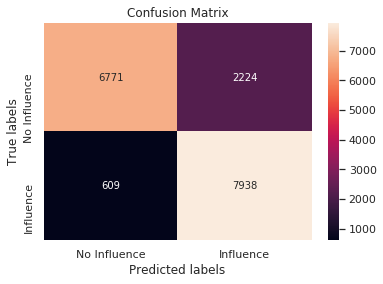

In [63]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
cm = confusion_matrix(y_test, y_pred)
#cm
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax , fmt='g')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Influence', 'Influence']); ax.yaxis.set_ticklabels(['No Influence', 'Influence'])
plt.savefig('Confusion_default')

## GridSearch

In [54]:


params = {
        'min_child_weight': [1,3, 5, 10],
        'gamma': [0.5, 0.1 , 0.8 ],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5 , 7 , 10 , 20] , 
        'n_estimators' : [20,50,100,200] , 
        'reg_alpha' : [0.1,0.3,0.7]
        }

folds = 3
parameter_combinations = 500

stratified_kfold = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 42 )
random_search = RandomizedSearchCV(XGBClassifier(), param_distributions=params, n_iter=parameter_combinations,
                                   scoring='accuracy',n_jobs=4, cv=stratified_kfold.split(X_train_scaled,y_train),
                                   verbose=2, random_state=42 )
random_search.fit(X_train_scaled, y_train , verbose=2)




Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   13.9s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  6.8min
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:  9.8min
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed: 13.7min
[Parallel(n_jobs=4)]: Done 1500 out of 1500 | elapsed: 14.1min finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7efe1627adb0>,
                   error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logi...
                   iid='deprecated', n_iter=500, n_jobs=4,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 0.1, 0.8],
                                        'm

In [55]:
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best Score:')
print(random_search.best_score_ )
print('\n Best hyperparameters:')
print(random_search.best_params_)


 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6, verbosity=1)

 Best Score:
0.8550172249505241

 Best hyperparameters:
{'n_estimators': 50, 'max_depth': 10, 'colsample_bytree': 1.0, 'min_child_weight': 1, 'gamma': 0.1, 'reg_alpha': 0.3, 'subsample': 0.6}


In [56]:
model = random_search.best_estimator_
model.fit(X_train_scaled , y_train)
y_pred = model.predict(X_test_scaled)
#from sklearn.metrics import confusion_matrix
#confusion_matrix(y_test, y_pred)



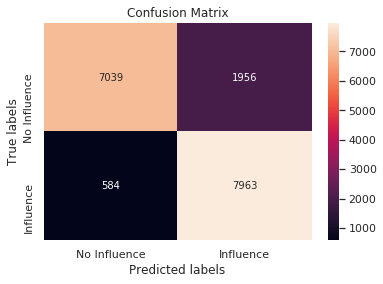

In [57]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
cm = confusion_matrix(y_test, y_pred)
#cm
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax , fmt='g')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Influence', 'Influence']); ax.yaxis.set_ticklabels(['No Influence', 'Influence'])
plt.savefig('Confusion_default')

In [58]:
f1_score(y_test, y_pred)

0.8624499079389147

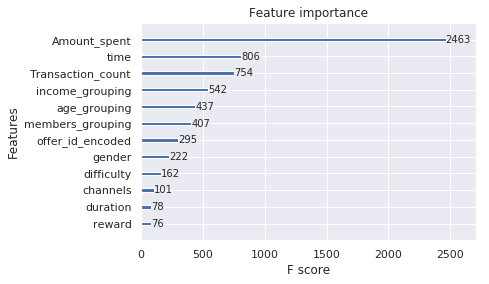

In [59]:
# plot feature importance
#from matplotlib import pyplot

#plot_importance(model)
ax = plot_importance(model)
ax.figure.savefig('feat_imp.png')